This is the notebook where I will generate all climate-related figures for the first EB paper.

In [2]:
import xarray as xr 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import scipy.stats as ss
import copy
from scipy.stats import gaussian_kde

In [3]:
fp_base = '/trace/home/cvwilson/'
fp_MERRA = fp_base + 'research/climate_data/MERRA2/'
fp_AWS = fp_base + 'research/climate_data/AWS/'
fn_MERRA = fp_MERRA + 'VAR/MERRA2_VAR_60_-150.nc'
fn_MERRA_gp = fp_MERRA + 'MERRA2constants.nc4'
fn_CLAWS = fp_AWS + 'Preprocessed/gulkana2024.csv'
fn_nunatak = fp_AWS + 'gulkana_1/1725/LVL2/gulkana1725_hourly_LVL2_ALL.csv'
fn_ridge = fp_AWS + 'gulkana_1/1480/LVL2/gulkana1480_hourly_LVL2_ALL.csv'
store_quantiles_fn = fp_base + 'research/PyGEM-EB/data/quantile_mapping_VAR.csv'
store_fig_fn = fp_base + 'research/climate_data/all_quantile_mapping.png'

# Gulkana location
lat = 63.5
lon = -145.625

# Spme constants
lapse_rate = -6.5
elev_CLAWS = 1682
elev_nunatak = 1725
elev_ridge = 1480
elev_MERRA2 = xr.open_dataarray(fn_MERRA_gp).sel(lat=lat,lon=lon).values[0] / 9.81

In [4]:
# Generate ALL files
# fn_aws = fn_nunatak
# df_all = None
# for year in np.arange(2000,2025):
#     fn = fn_aws.replace('ALL',str(year)) # .replace('hourly','15min')
#     if os.path.exists(fn):
#         df = pd.read_csv(fn,index_col='UTC_time')
#         if df_all is None:
#             df_all = copy.deepcopy(df)
#         else:
#             df_all = pd.concat([df_all, df])
# df_all.to_csv(fn_aws) #.replace('hourly','15min'))

### USEFUL FUNCTIONS

In [5]:
def quantile_mapping(data_AWS,data_MERRA,var=None):
    # Sort MERRA data and align AWS data accordingly
    sorted_indices = np.argsort(data_MERRA)
    data_MERRA_sorted = data_MERRA[sorted_indices]
    data_AWS_sorted = data_AWS[sorted_indices]

    # Compute empirical CDF
    reanalysis_cdf = (ss.rankdata(data_MERRA_sorted, method="average") - 1) / (len(data_MERRA_sorted) - 1)

    # Map MERRA quantiles to AWS quantiles
    quantile_map = np.interp(reanalysis_cdf, np.sort(reanalysis_cdf), np.sort(data_AWS_sorted))

    # Store data if executed with a var
    if var is not None:
        fn = store_quantiles_fn.replace('VAR',var)
        df = pd.DataFrame({'sorted': data_MERRA_sorted, 'mapping': quantile_map})
        df.to_csv(fn)

    return data_MERRA_sorted, quantile_map

def plot_quantile(X_train, y_train, y_all, lims, var=None, plot_kde=False, plot_axes=None):
    if var is not None:
        df = pd.read_csv(store_quantiles_fn.replace('VAR',var))
        sorted = df['sorted'].values
        mapping = df['mapping'].values
    else:
        # Train quantile map
        sorted, mapping = quantile_mapping(X_train, y_train)

    # Plot it
    if plot_axes is None:
        fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(8,2.75),gridspec_kw={'wspace':0.3})
    else:
        (ax1,ax2,ax3) = plot_axes

    # Raw scatter
    if plot_kde:
        kde = gaussian_kde([X_train, y_train])
        density = kde(np.vstack([X_train, y_train]))
        ax1.scatter(X_train, y_train, s=3, c=density, cmap=plt.cm.magma)
    else:
        ax1.scatter(X_train, y_train, s=3, c='k')
    ax1.plot(lims,lims,'k--',label='1:1')
    ax1.legend()
    ax1.set_xlabel('AWS',fontsize=11)
    ax1.set_ylabel('MERRA-2',fontsize=11)
    ax1.set_title('Raw data')

    # Updated scatter
    updated = np.interp(y_train, sorted, mapping)
    if plot_kde:
        kde = gaussian_kde([X_train, updated])
        density = kde(np.vstack([X_train, updated]))
        ax2.scatter(X_train, updated, s=3, c=density, cmap=plt.cm.magma)
    else:
        ax2.scatter(X_train, updated, s=3, c='k')
    ax2.plot(lims,lims,'k--',label='1:1')
    ax2.set_xlabel('AWS',fontsize=11)
    ax2.set_title('Adjusted data')

    # Distributions
    updated_all = np.interp(y_all, sorted, mapping)
    _,hist_bins = np.histogram(X_train)
    ax3.hist(y_all,bins=hist_bins,histtype='step',label='Raw MERRA',linestyle='--',density=True)
    ax3.hist(updated_all,bins=hist_bins,histtype='step',label='Adj. MERRA',density=True)
    ax3.hist(X_train,bins=hist_bins,histtype='step',label='AWS',density=True)
    ax3.legend()
    ax3.set_title('Entire distribution')

    # All axes
    for ax in [ax1,ax2]:
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.tick_params(length=5)

    if plot_axes is None:
        return fig, (ax1,ax2,ax3)
    else:
        return ax1,ax2,ax3

## BIAS ADJUSTMENTS
### TEMPERATURE

In [6]:
temp_MERRA2 = xr.open_dataarray(fn_MERRA.replace('VAR','T2M')).sel(lat=lat,lon=lon)
temp_nunatak = pd.read_csv(fn_nunatak,index_col='UTC_time')['site_temp_USGS']
temp_CLAWS = pd.read_csv(fn_CLAWS,index_col=0)['temp']

# Adjust MERRA-2 to the same elevation as the nunatak
temp_MERRA2 += (elev_nunatak - elev_MERRA2) * lapse_rate / 1000

# Fix units
temp_MERRA2 -= 273.15

# Sort out time and find dates where AWS recorded temperature
all_temp = temp_MERRA2.values
temp_nunatak.index = pd.to_datetime(temp_nunatak.index)
temp_CLAWS.index = pd.to_datetime(temp_CLAWS.index) + pd.Timedelta(hours=8)
dates_data = temp_nunatak.index[~np.isnan(temp_nunatak)]
dates_data = dates_data[dates_data >= pd.to_datetime('2000-01-01 00:00')]
dates_data = dates_data[dates_data <= pd.to_datetime('2024-08-31 00:00')]

# Select dates where AWS has data
temp_MERRA2 = temp_MERRA2.interp(time=pd.to_datetime(dates_data))
temp_nunatak = temp_nunatak.loc[dates_data]

# Correct nunatak temperature data to the on-ice AWS
# dates_2024 = np.sort(list(set(temp_CLAWS.index) & set(temp_nunatak.index)))
# temp_CLAWS = temp_CLAWS.loc[dates_2024].sort_index()
# temp_nunatak_2024 = temp_nunatak.loc[dates_2024] + (elev_CLAWS - elev_nunatak) * lapse_rate / 1000
# fig,ax = plt.subplots()
# ax.plot(dates_2024, temp_CLAWS, label='on-ice')
# ax.plot(dates_2024, temp_nunatak_2024,label='nunatak')
# ax.set_ylabel('Temperature ($\circ$C)')
# ax.legend()
# ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
# plt.show()

#### QUANTILE MAPPING

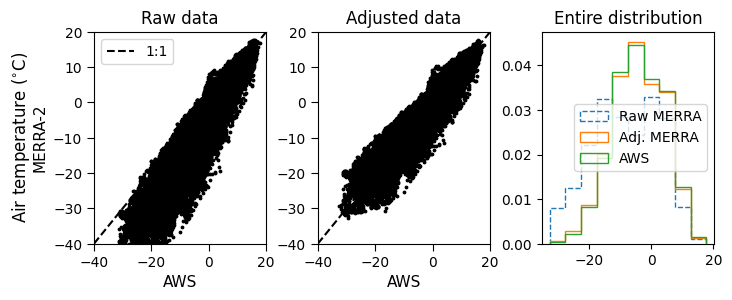

In [7]:
# Separate data into train and test
X_temp = temp_nunatak.values
y_temp = temp_MERRA2.values

# Plot
quantile_mapping(X_temp, y_temp, 'temp')
fig, axes = plot_quantile(X_temp, y_temp, all_temp, [-40, 20], plot_kde=False)
fig.supylabel('Air temperature ($^{\circ}$C)')
plt.show()

### INCOMING SHORTWAVE

In [8]:
SWin_MERRA2 = xr.open_dataarray(fn_MERRA.replace('VAR','SWGDN')).sel(lat=lat,lon=lon)
SWin_nunatak = pd.read_csv(fn_nunatak,index_col='UTC_time')['ShortwaveIn'].astype(float)

# Filter negative values
SWin_nunatak.loc[SWin_nunatak < 1] = 0
SWin_nunatak.loc[SWin_nunatak > 4e3] = np.nan

# Fix units
SWin_MERRA2 *= 3600
SWin_nunatak *= 3600

# Sort out time and find dates where AWS recorded SWin
all_SWin = SWin_MERRA2.values
all_time = pd.to_datetime(SWin_MERRA2.time.values)
SWin_nunatak.index = pd.to_datetime(SWin_nunatak.index)
dates_data = SWin_nunatak.index[~np.isnan(SWin_nunatak)]
dates_data = dates_data[dates_data >= pd.to_datetime('2015-01-01 00:00')]
dates_data = dates_data[dates_data <= pd.to_datetime('2023-08-31 00:00')]

# Select dates where AWS has data
SWin_MERRA2 = SWin_MERRA2.interp(time=pd.to_datetime(dates_data))
SWin_nunatak = SWin_nunatak.loc[dates_data]

In [9]:
# SWin_MERRA2 = SWin_MERRA2.isel(time=np.arange(len(dates_data))[5:])
# SWin_nunatak = SWin_nunatak.iloc[:-5]
# SWin_nunatak.index = SWin_nunatak.index + pd.Timedelta(hours=5)
# time = pd.date_range('2013-05-20','2013-05-22',freq='h')
# time = pd.date_range(dates_data[1200], dates_data[1224],freq='h')
# plt.scatter(SWin_nunatak.index, SWin_nunatak.values, label='Nunatak')
# plt.scatter(SWin_MERRA2.time.values, SWin_MERRA2.values, label='MERRA2')
# plt.xlim(time[0], time[-1])
# plt.legend()
# plt.show()
# plt.scatter(SWin_nunatak.index.hour, SWin_nunatak.values)

# plt.scatter(SWin_nunatak.index.hour, SWin_MERRA2.values)

# plt.xlabel('Hour of day')
# plt.ylabel('Incoming Shortwave')

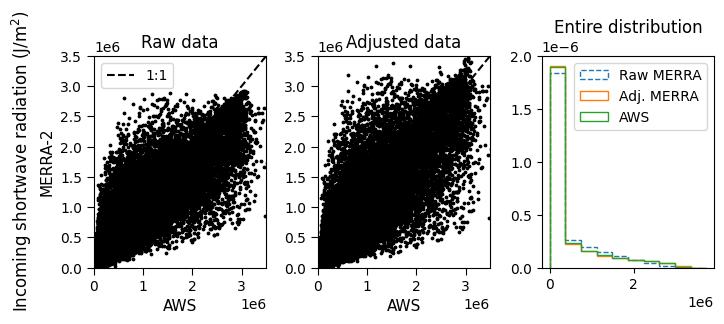

In [10]:
# Filter 0s
# index_not0 = np.where((SWin_MERRA2.values > 0) & (SWin_nunatak.values > 0))[0]
# index_not0 = np.arange(len(SWin_nunatak.index))
# all_SWin = all_SWin[np.where(all_SWin > 0)[0]]

# Specify X and y
X_SWin = SWin_nunatak.values # [index_not0]
y_SWin = SWin_MERRA2.values # [index_not0]

# Save quantiles
quantile_mapping(X_SWin, y_SWin, 'SWin')

# Plot 
fig, (ax1,ax2,ax3) = plot_quantile(X_SWin, y_SWin, all_SWin, [0,3.5e6], var='SWin', plot_kde=False)
fig.supylabel('Incoming shortwave radiation (J/m$^{2}$)')
plt.show()

In [11]:
fn_nunatak

'/trace/home/cvwilson/research/climate_data/AWS/gulkana_1/1725/LVL2/gulkana1725_hourly_LVL2_ALL.csv'

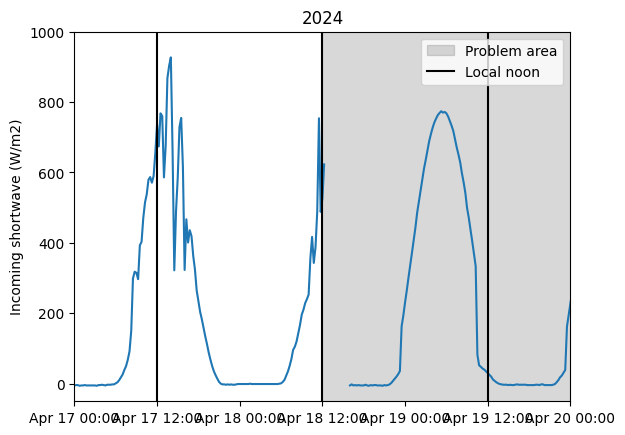

In [103]:
df = pd.read_csv(fn_nunatak.replace('ALL','2024').replace('hourly','15min'), index_col = 'local_time')['ShortwaveIn']
df.index = pd.to_datetime(df.index) # +pd.Timedelta(hours=8)
fig,ax = plt.subplots()
ax.plot(df.index, df.values)
start = pd.to_datetime('2024-04-17 00:00')
end = start + pd.Timedelta(days=3)
ax.set_xlim(start,end)
ax.fill_between(pd.date_range('2024-04-18 12:00','2024-05-01 13:00',freq='15min'),-100,1500,color='gray',alpha=0.3,label='Problem area')
ax.axvline(start + pd.Timedelta(hours=12), color='black',label='Local noon')
ax.axvline(start + pd.Timedelta(hours=12,days=1),color='k')
ax.axvline(start + pd.Timedelta(hours=12,days=2),color='k')
ax.set_ylim(-50,1000)
# # plt.axvline(start + pd.Timedelta(hours=12,days=2), color='r')
# df1 = df.loc[pd.to_datetime('2023-10-01 00:15'):pd.to_datetime('2024-04-18')]
# df2 = df.loc[pd.to_datetime('2024-04-19'):pd.to_datetime('2024-09-30')]
# plt.scatter(df1.index.hour, df1,label='Before April, 2014')
# plt.scatter(df2.index.hour, df2,label='After August 26, 2014')
# plt.xlabel('Local time')
# plt.ylabel('')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d %H:00'))
ax.set_xticks(pd.date_range(start, end, freq='12h'))
ax.set_ylabel('Incoming shortwave (W/m2)')
ax.legend()
ax.set_title('2024')
plt.show()

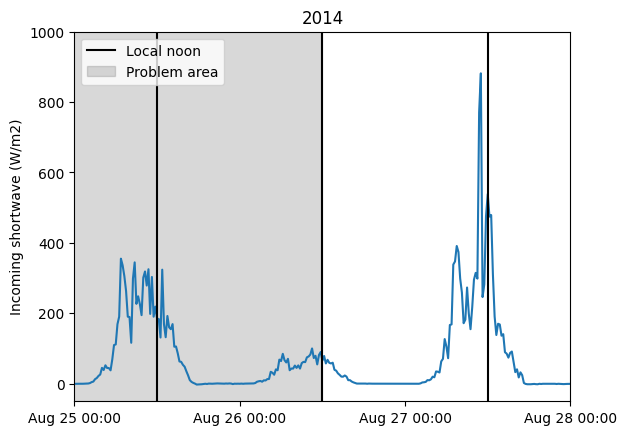

In [105]:
df = pd.read_csv(fn_nunatak.replace('ALL','2012').replace('hourly','15min'), index_col = 'local_time')['ShortwaveIn']
df.index = pd.to_datetime(df.index)
fig,ax = plt.subplots()
ax.plot(df.index, df.values)
start = pd.to_datetime('2012-08-25 00:00')
end = start + pd.Timedelta(days=3)
ax.set_xlim(start,end)
ax.axvline(start + pd.Timedelta(hours=12), color='black',label='Local noon')
ax.axvline(start + pd.Timedelta(hours=12,days=1),color='k')
ax.axvline(start + pd.Timedelta(hours=12,days=2),color='k')

ax.fill_between(pd.date_range('2012-08-20','2012-08-26 12:00',freq='15min'),-100,1500,color='gray',alpha=0.3,label='Problem area')
ax.set_ylim(-50,1000)
# # plt.axvline(start + pd.Timedelta(hours=12,days=2), color='r')
# df1 = df.loc[pd.to_datetime('2023-10-01 00:15'):pd.to_datetime('2024-04-18')]
# df2 = df.loc[pd.to_datetime('2024-04-19'):pd.to_datetime('2024-09-30')]
# plt.scatter(df1.index.hour, df1,label='Before April, 2014')
# plt.scatter(df2.index.hour, df2,label='After August 26, 2014')
# plt.xlabel('Local time')
# plt.ylabel('')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d %H:00'))
ax.set_xticks(pd.date_range(start, end, freq='24h'))
ax.legend()
ax.set_title('2014')
ax.set_ylabel('Incoming shortwave (W/m2)')

plt.show()

2012-04-18 16:00:00 2012-09-30 23:00:00
2012-10-01 00:00:00 2013-09-30 23:00:00
2013-10-01 00:00:00 2014-09-30 23:00:00
2014-10-01 00:00:00 2015-09-30 23:00:00
2015-10-01 00:00:00 2016-09-30 23:00:00
2016-10-01 00:00:00 2017-09-30 23:00:00
2017-10-01 00:00:00 2018-09-30 23:00:00
2018-10-01 00:00:00 2019-09-30 23:00:00
2019-10-01 00:00:00 2020-09-30 23:00:00
2020-10-01 00:00:00 2021-09-30 23:00:00
2021-10-01 00:00:00 2022-09-30 23:00:00
/trace/home/cvwilson/research/climate_data/AWS/gulkana_1/1725/LVL2/gulkana1725_hourly_LVL2_2023.csv
2023-10-01 00:00:00 2024-09-30 23:00:00


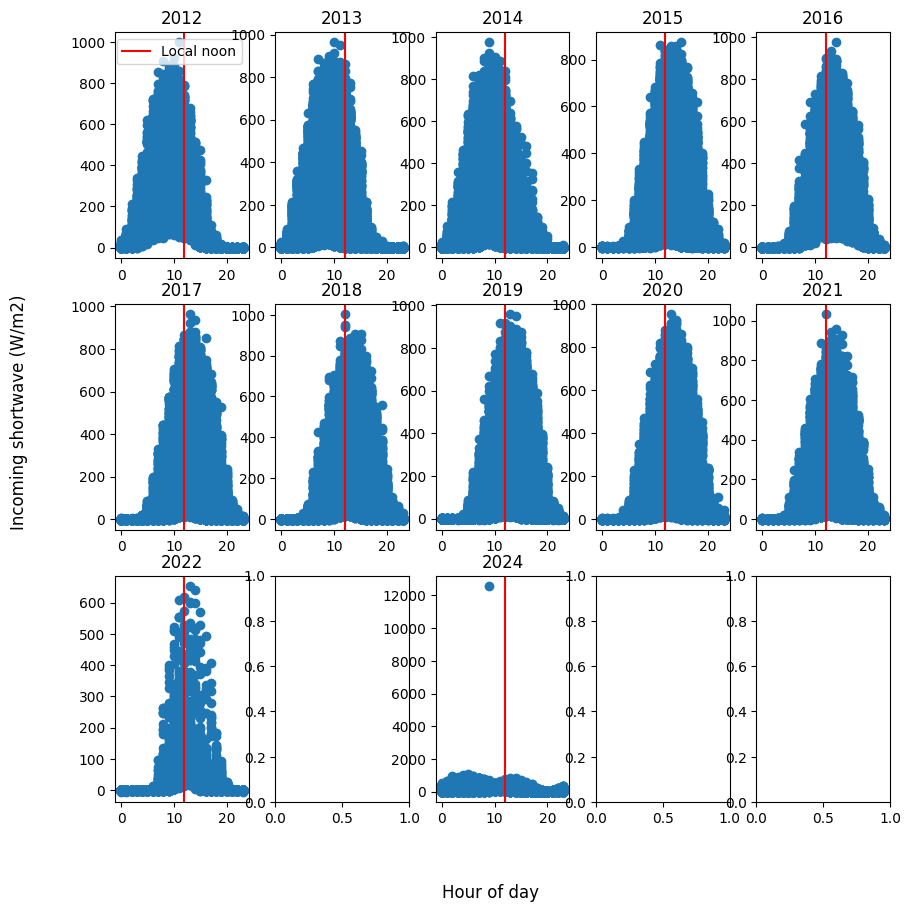

In [14]:
base_fp = '/trace/home/cvwilson/research/climate_data/AWS/'
fig,axes = plt.subplots(3,5,figsize=(10,10))
axes = axes.flatten()
for y,year in enumerate(np.arange(2012,2025)):
    fn = fn_nunatak.replace('ALL',str(year))
    ax = axes[y]
    try:
        df = pd.read_csv(fn, index_col = 'local_time')['ShortwaveIn']
    except:
        print(fn)
        continue
    df.index = pd.to_datetime(df.index)
    print(df.index[0], df.index[-1])
    
    ax.scatter(df.index.hour, df.values)
    ax.set_title(str(year))
    ax.axvline(12, color='red',label='Local noon')
    # ax.set_xlim(pd.to_datetime(f'{year}-08-20'), pd.to_datetime(f'{year}-08-22'))
    # ax.set_title(str(year))
    # ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H'))
    # plt.show()
axes[0].legend()
fig.supxlabel('Hour of day')
fig.supylabel('Incoming shortwave (W/m2)')
plt.show()

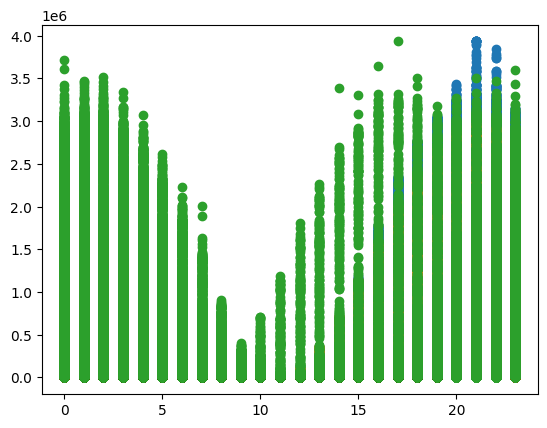

In [51]:
sorted, mapping = quantile_mapping(X_SWin, y_SWin)
updated = np.interp(all_SWin, sorted, mapping)
fig, ax = plt.subplots()
ax.scatter(all_time.hour, updated)
ax.scatter(all_time.hour, all_SWin)
ax.scatter(SWin_nunatak.index.hour, SWin_nunatak.values)
# ax.set_xlim(pd.to_datetime('2024-04-20'),pd.to_datetime('2024-04-22'))
# ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H'))

### WIND SPEED

In [120]:
uwind_MERRA2 = xr.open_dataarray(fn_MERRA.replace('VAR','U2M')).sel(lat=lat,lon=lon)
vwind_MERRA2 = xr.open_dataarray(fn_MERRA.replace('VAR','V2M')).sel(lat=lat,lon=lon)
wind_MERRA2 = uwind_MERRA2.copy(deep=True)
all_wind = np.sqrt(np.square(uwind_MERRA2.values) + np.square(vwind_MERRA2.values))
wind_MERRA2.values = all_wind
wind_CLAWS = pd.read_csv(fn_CLAWS,index_col=0)['uwind']

# Sort out time and find dates where AWS recorded wind speed
wind_CLAWS.index = pd.to_datetime(wind_CLAWS.index) + pd.Timedelta(hours=5)
dates_data = wind_CLAWS.index[~np.isnan(wind_CLAWS)]
dates_data = dates_data[dates_data >= pd.to_datetime('2000-01-01 00:00')]
dates_data = dates_data[dates_data <= pd.to_datetime('2024-08-31 00:00')]

# Select dates where AWS has data
wind_MERRA2 = wind_MERRA2.interp(time=pd.to_datetime(dates_data))
wind_CLAWS = wind_CLAWS.loc[dates_data]

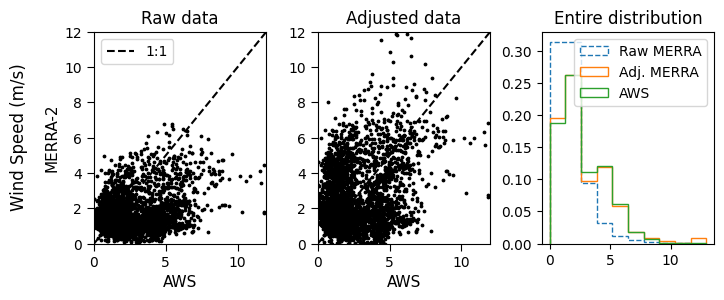

In [121]:
# Training data is ALL the 2024 summer
X_wind = wind_CLAWS.values
y_wind = wind_MERRA2.values

# Save quantiles
quantile_mapping(X_wind, y_wind, 'wind')

# Plot
lims = [0, 12]
fig, axes = plot_quantile(X_wind, y_wind, all_wind, lims, 'wind')
fig.supylabel('Wind Speed (m/s)')
plt.show()

### RELATIVE HUMIDITY

In [122]:
RH_MERRA2 = xr.open_dataarray(fn_MERRA.replace('VAR','RH2M')).sel(lat=lat,lon=lon)
RH_ridge = pd.read_csv(fn_ridge,index_col='UTC_time')['RelHum']
all_rh = RH_MERRA2.values

# Filter negative values
RH_ridge[RH_ridge < 0] = 0
RH_ridge[RH_ridge > 100] = 100

# Sort out time and find dates where AWS recorded RH
RH_ridge.index = pd.to_datetime(RH_ridge.index)
dates_data = RH_ridge.index[~np.isnan(RH_ridge)]
dates_data = dates_data[dates_data >= pd.to_datetime('2000-01-01 00:00')]
dates_data = dates_data[dates_data <= pd.to_datetime('2024-08-31 00:00')]

# Select dates where AWS has data
RH_MERRA2 = RH_MERRA2.interp(time=pd.to_datetime(dates_data))
RH_ridge = RH_ridge.loc[dates_data]

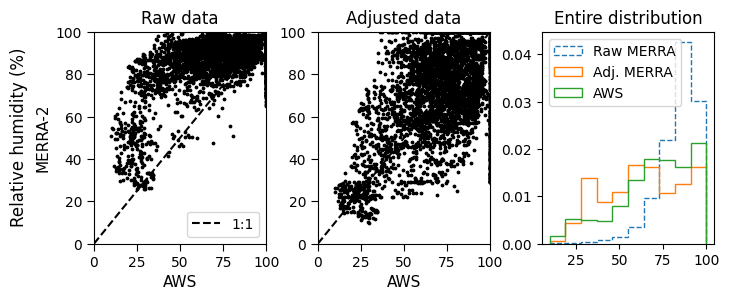

In [123]:
# Separate data into train and test
X_rh = RH_ridge.values
y_rh = RH_MERRA2.values

# Save quantiles
quantile_mapping(X_rh, y_rh, 'RH')

# Plot 
fig, (ax1,ax2,ax3) = plot_quantile(X_rh, y_rh, all_rh, [0,100])
fig.supylabel('Relative humidity (%)')
plt.show()

## All plots

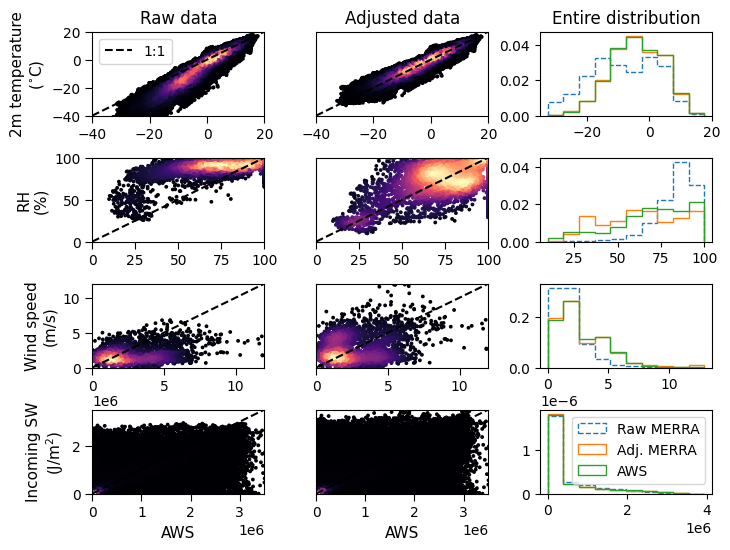

In [ ]:
all_dict = {'temp':{'X':X_temp,'y':y_temp,'all':all_temp,'label':'2m temperature\n($^{\circ}$C)','lims':[-40,20]},
            'rh':{'X':X_rh,'y':y_rh,'all':all_rh,'label':'RH\n(%)','lims':[0,100]},
            'wind':{'X':X_wind,'y':y_wind,'all':all_wind,'label':'Wind speed\n(m/s)','lims':[0,12]},
            'SWin':{'X':X_SWin,'y':y_SWin,'all':all_SWin,'label':'Incoming SW\n(J/m$^{2}$)','lims':[0,3.5e6]},
            }

# Takes 8 minutes with kde on
plot_kde = True
fig, plots = plt.subplots(4, 3, figsize=(8,6), gridspec_kw={'hspace':0.5,'wspace':0.3})
for v,var in enumerate(all_dict):
    X = all_dict[var]['X']
    y = all_dict[var]['y']
    all = all_dict[var]['all']
    plots[v, :] = plot_quantile(X,y,all, all_dict[var]['lims'], plot_kde=plot_kde, plot_axes = plots[v, :])
    plots[v,0].set_ylabel(all_dict[var]['label'])
for row,axrow in enumerate(plots):
    for col, ax in enumerate(axrow):
        if row > 0:
            ax.set_title('')
        if row > 0 and col == 0:
            ax.legend().remove()
        if row < 3 and col == 2:
            ax.legend().remove()
        if col == 1:
            ax.set_yticks([])
        if row < 3:
            ax.set_xlabel('')
plt.savefig(store_fig_fn, dpi=300, bbox_inches='tight')
plt.show()

## PRECIPITATION ANALYSIS
### REGRESSION OF KP

In [43]:
# Come back and do this on Torch because I already have get_kp.py there

### VIOLIN PLOTS OF PRECIP TYPE

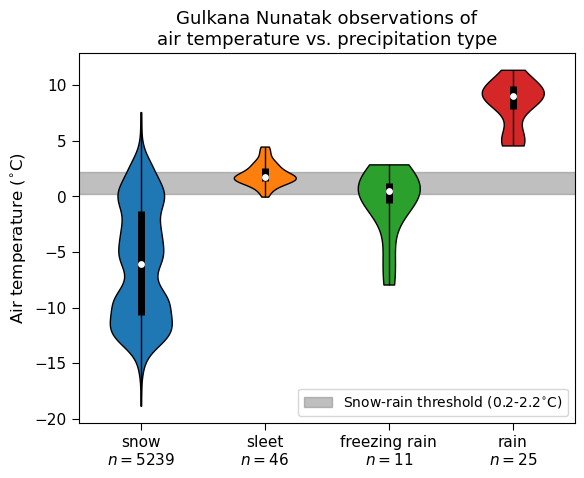

In [24]:
tp_type_nunatak = pd.read_csv(fn_nunatak.replace('hourly','15min'), index_col='UTC_time')
all_temps = tp_type_nunatak['site_temp'] - 1 + (elev_CLAWS - elev_nunatak) * lapse_rate / 1000
types = tp_type_nunatak['PrecipType']

# Sort by type
temps = {'snow':all_temps[types == 70.],
        'sleet': all_temps[types == 69.],
        'freezing rain': all_temps[types == 67.],
        'rain':all_temps[types == 60.]} # 'none':all_temps[types == 0.], 
temps['rain'] = temps['rain'][temps['rain'] > -5]
temps['snow'] = temps['snow'][temps['snow'] > -25]

# Create the violin plot
fig,ax = plt.subplots()
ticklabels = []
for i,ptype in enumerate(temps):
    n = len(temps[ptype])
    ticklabels.append(f'{ptype}\n$n={n}$')
    parts = ax.violinplot(temps[ptype],[i],showextrema=False)
    for pc in parts['bodies']:
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    quartile1, medians, quartile3 = np.percentile(temps[ptype], [25, 50, 75])
    ax.vlines([i], quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax.vlines([i], np.min(temps[ptype]), np.max(temps[ptype]), color='k', linestyle='-', lw=1)
    ax.scatter([i], medians, marker='o', color='white', s=15, zorder=5)

ax.set_xticks(np.arange(len(temps)))
ax.set_xticklabels(ticklabels)
ax.fill_between([-2,5],0.2,2.2,color='gray',alpha=0.5,zorder=-1,label='Snow-rain threshold (0.2-2.2$^{\circ}$C)')
ax.legend(loc='lower right')
ax.set_xlim([-0.5,len(temps)-0.5])
ax.set_ylabel('Air temperature ($^{\circ}$C)',fontsize=12)
ax.set_title('Gulkana Nunatak observations of\nair temperature vs. precipitation type',fontsize=13)
ax.tick_params(length=5,labelsize=11)
plt.show()

(Temperature Linear Regression)

In [ ]:
# Perform regression on all nunatak and MERRA-2 temperatures
X = np.vstack([temp_MERRA2.values, np.ones_like(temp_MERRA2.values)]).T
y = temp_nunatak.values
result,resid = np.linalg.lstsq(X,y,rcond=None)[:2]
slope = result[0]
intercept = result[1]

# Plot it
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

# Raw
ax1.scatter(temp_MERRA2.values, temp_nunatak.values, s=3)
xrange = np.linspace(-40,20,200)
ax1.plot(xrange,xrange*slope + intercept,'r:',label=f'$y={slope:.3f}x+{intercept:.3f}$')
ax1.plot([-30,20],[-30,20],'k--',label='1:1')
ax1.legend()
ax1.set_title('Raw data and linear fit')

# Updated
ax2.scatter(temp_MERRA2.values * slope + intercept, temp_nunatak.values, s=3)
ax2.plot([-30,20],[-30,20],'k--',label='1:1')
ax2.legend()
ax2.set_title('Adjusted data')

# Both
for ax in [ax1,ax2]:
    ax.set_xlim(-30,20)
    ax.set_ylim(-30,20)
    ax.tick_params(length=5)
plt.show()